In [316]:
import matplotlib.pyplot as plt
from api import api
from utils import combineIndicators
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import seaborn as sns
from itertools import product


In [317]:

apiCaller = api()

countries = apiCaller.getCountries()
lifeExpectancy = apiCaller.getValues("WHOSIS_000001")
popuation = apiCaller.getValues("RS_1845")
alcoholConsumption = apiCaller.getValues("SA_0000001688")
hospitalBeds = apiCaller.getValues("WHS6_102")
hdiRanking = apiCaller.getValues("CCO_2")
gniPerCapita = apiCaller.getValues("RS_576")
hospitalDensity = apiCaller.getValues("DEVICES00")
ict = apiCaller.getValues("ITU_IDI")
nutritionScore = apiCaller.getValues("NLIS_NU_CA_023")
cigaretteLowestPrice = apiCaller.getValues("R_Price_lowest_cost_usd")
povertyRate = apiCaller.getValues("NLIS_NU_CA_084")
beerPrice = apiCaller.getValues("SA_0000001829")
openDefecation = apiCaller.getValues("WSH_SANITATION_OD")
healthExpenditure = apiCaller.getValues("GHED_CHEGDP_SHA2011")
indicators = [lifeExpectancy,popuation,alcoholConsumption,hospitalBeds,hdiRanking,gniPerCapita,hospitalDensity,ict,nutritionScore,cigaretteLowestPrice,povertyRate,beerPrice,openDefecation,healthExpenditure]

df = pd.DataFrame(combineIndicators(countries,indicators)).T
# usuniecie wierszy ktore nie maja targetu - life expectancy
df.dropna(subset=[df.columns[0]],how='any',inplace=True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col],errors='coerce')
df.sort_values(by=df.columns[0],ascending=False,inplace=True)
df.info()




<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, Portugal to Burundi
Data columns (total 14 columns):
 #   Column                                                                                         Non-Null Count  Dtype  
---  ------                                                                                         --------------  -----  
 0   Life expectancy at birth (years)                                                               183 non-null    float64
 1   Population                                                                                     173 non-null    float64
 2   Alcohol, total per capita (15+) consumption (in litres of pure alcohol) (SDG Indicator 3.5.2)  178 non-null    float64
 3   Hospital beds (per 10 000 population)                                                          178 non-null    float64
 4   Human development index rank                                                                   181 non-null    float64
 5   Gross national i

C:\Users\dziun\AppData\Local\Temp\ipykernel_14828\476845914.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df.columns,y=(df.isnull().sum() * 100 / len(df)),palette='viridis')
C:\Users\dziun\AppData\Local\Temp\ipykernel_14828\476845914.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(new_labels)


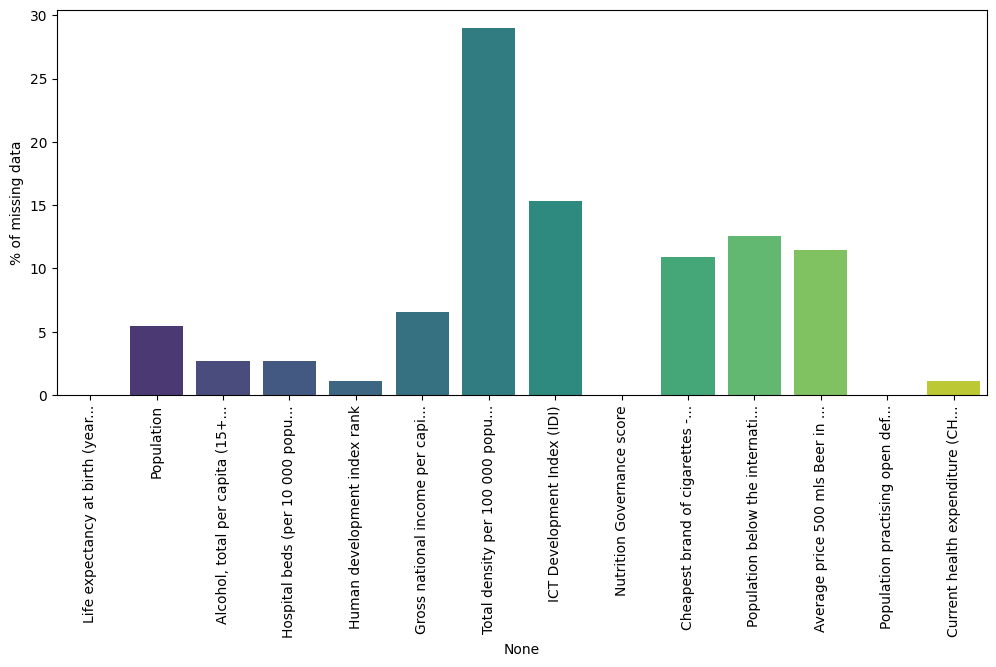

In [318]:
def show_missing_values(df):
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=df.columns,y=(df.isnull().sum() * 100 / len(df)),palette='viridis')
    plt.xticks(rotation=90)
    plt.ylabel('% of missing data')

    new_labels = []
    for label in ax.xaxis.get_ticklabels():
        label = label.get_text()
        if len(label)>30:
            new_labels.append(label[:30] + '...')
        else: 
            new_labels.append(label)
    ax.xaxis.set_ticklabels(new_labels)
    plt.show()
show_missing_values(df)

In [319]:
# usuniecie wierszy ktore maja brakujace wartosci w kolumnach 1-4
# uzupelnienie brakujacych wartosci w pozostalych kolumnach
df.dropna(subset=df.columns[1:6],how='any',inplace=True)
df.dropna(subset=df.columns[7:],how='any',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, Portugal to Zimbabwe
Data columns (total 14 columns):
 #   Column                                                                                         Non-Null Count  Dtype  
---  ------                                                                                         --------------  -----  
 0   Life expectancy at birth (years)                                                               114 non-null    float64
 1   Population                                                                                     114 non-null    float64
 2   Alcohol, total per capita (15+) consumption (in litres of pure alcohol) (SDG Indicator 3.5.2)  114 non-null    float64
 3   Hospital beds (per 10 000 population)                                                          114 non-null    float64
 4   Human development index rank                                                                   114 non-null    float64
 5   Gross national 

# Life expectancy buckets


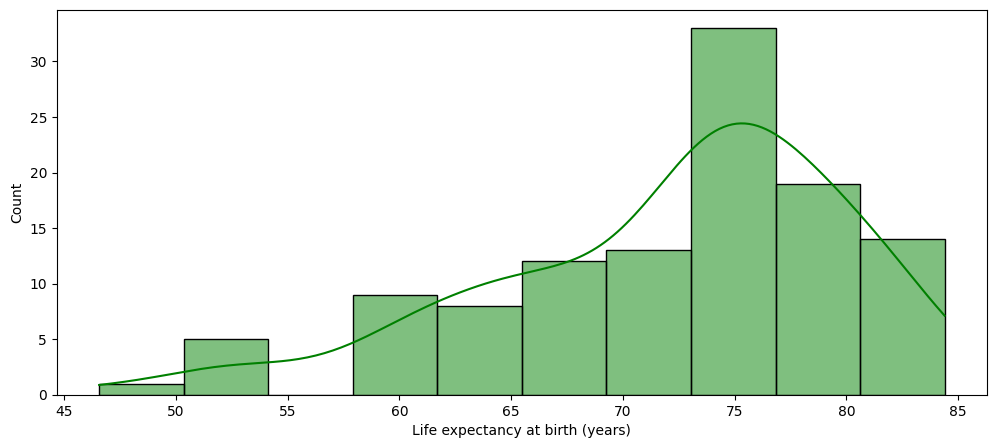

In [320]:
plt.figure(figsize=(12,5))
sns.histplot(df['Life expectancy at birth (years)'],bins=10,kde=True,color='green')
plt.show()

# Sample values per country
Presented sample values of "Life expectancy" per country

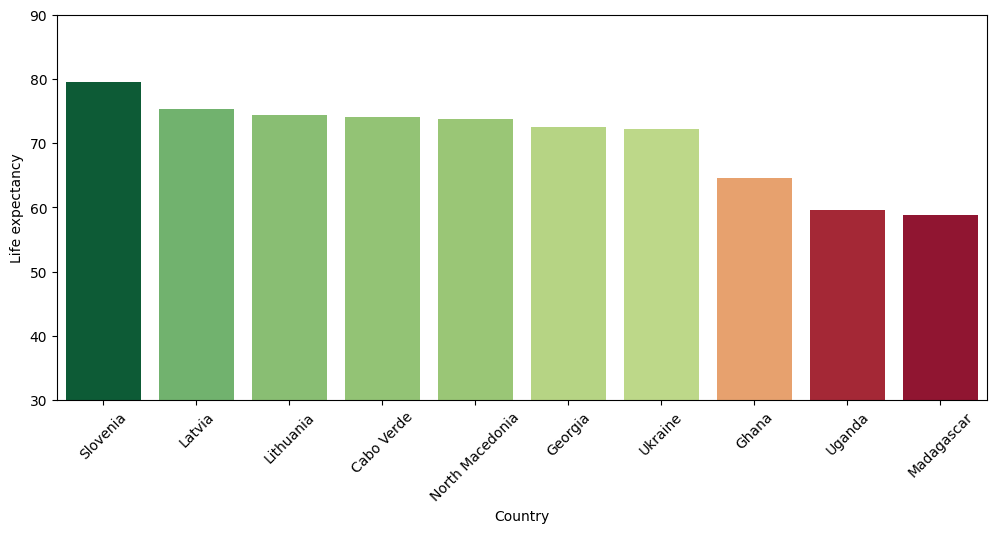

In [321]:
sample = df.sample(10)
sample = sample.sort_values(by=sample.columns[0],ascending=False)
plt.figure(figsize=(12,5))
sns.barplot(x=sample.index,y=sample[sample.columns[0]],hue=sample.columns[0],data=sample,legend=False,palette='RdYlGn')
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.ylabel("Life expectancy")
plt.ylim(30,90)
plt.show()

# Dependencies between indicators and target - Life expectancy

In [322]:
def visualise_scatter(x,y,data=None,show_reg=True,xlim=None,ylim=None):
    plt.figure(figsize=(12,5))
    sns.scatterplot(data=data,x=x,y=y,hue=y,palette='RdYlGn')
    if show_reg:
        sns.regplot(data=data,x=x,y=y,scatter=False,truncate=True,order=3,color='0.2')
    if ylim:
        plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
    plt.show()

### Population

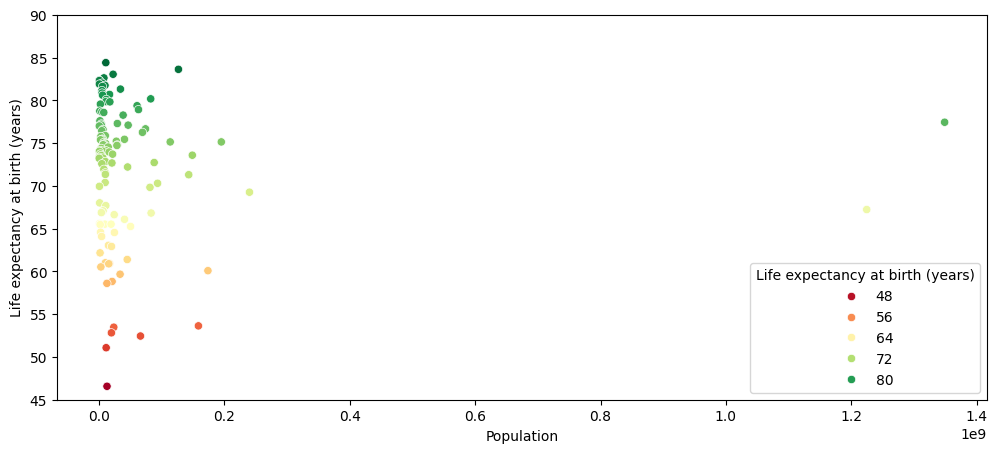

In [323]:
visualise_scatter(x=df.columns[1],y=df.columns[0],data=df,show_reg=False,ylim=(45,90))

as we can see, the population of the country doesn't have any impact on the life expectancy and it will only make the calculations less reliable, so it has to be erased later.


# Alcohol consumption per capita

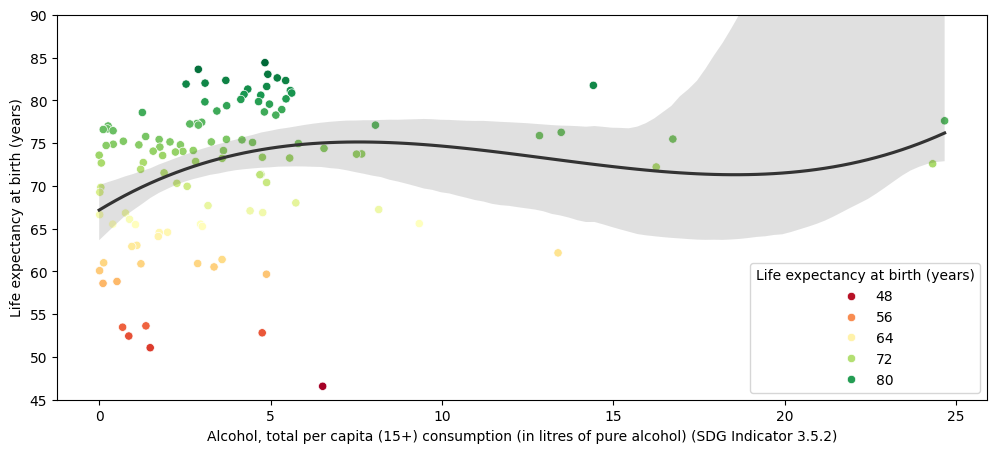

In [324]:
visualise_scatter(x=df.columns[2],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# Hospital beds

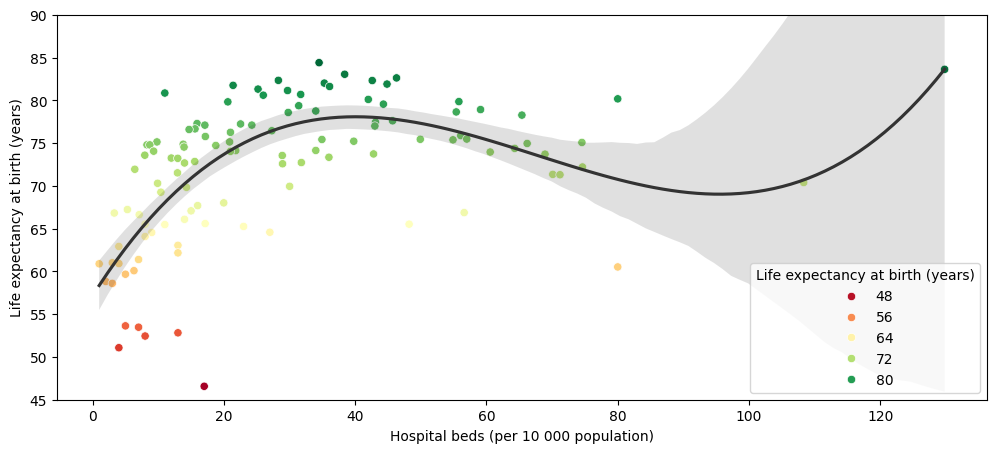

In [325]:
visualise_scatter(x=df.columns[3],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# HDI rank (1 - highest)

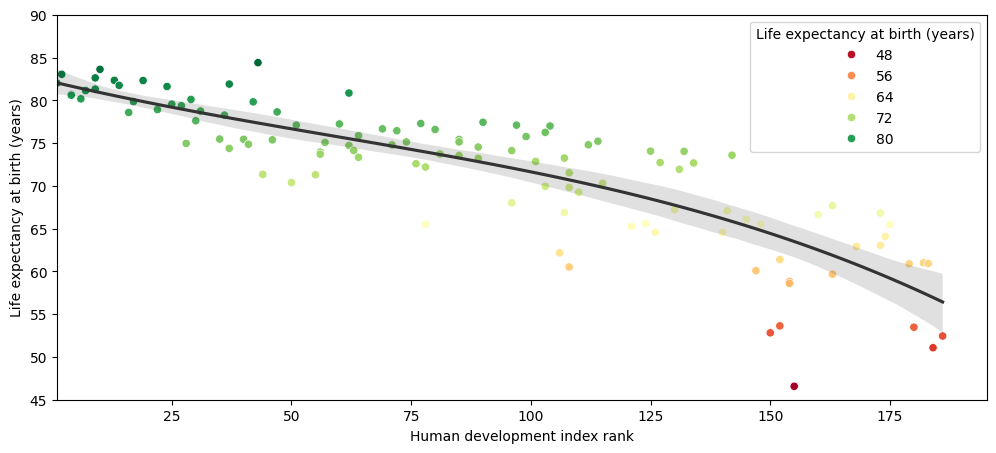

In [326]:
visualise_scatter(x=df.columns[4],y=df.columns[0],data=df,show_reg=True,ylim=(45,90),xlim=(1))

# GNI per capita

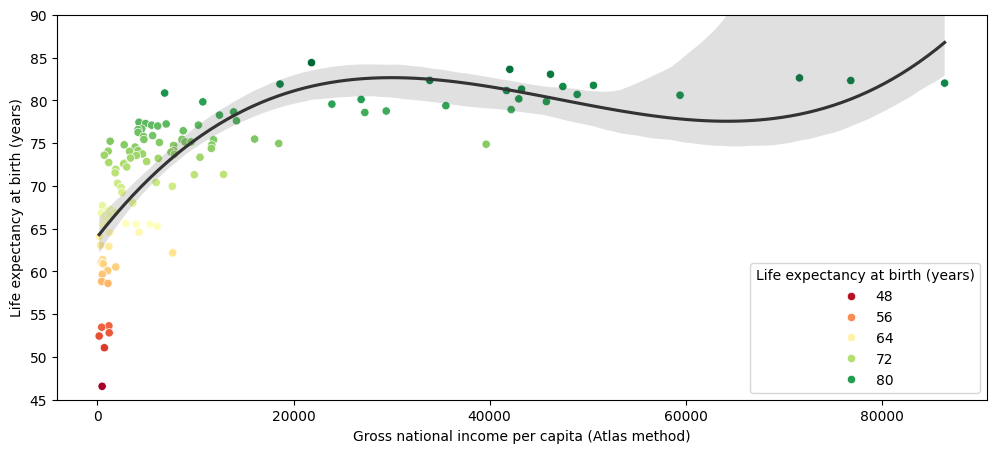

In [327]:
visualise_scatter(x=df.columns[5],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# Hospitals
the x axis has been limited, because some random country had hospital density set to 50 and it ruined the whole visualisation

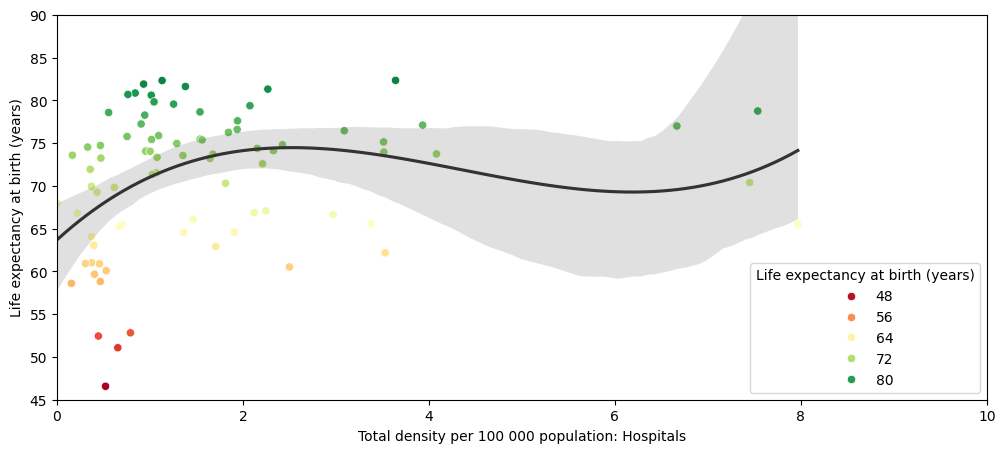

In [328]:
visualise_scatter(x=df.columns[6],y=df.columns[0],data=df,show_reg=True,ylim=(45,90),xlim=(0,10))

# ICT

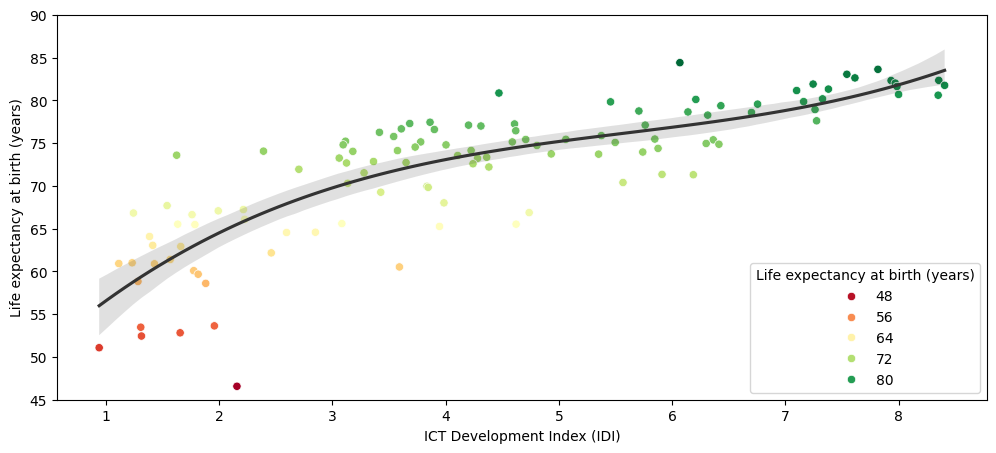

In [329]:
visualise_scatter(x=df.columns[7],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# Nutrition Governance score

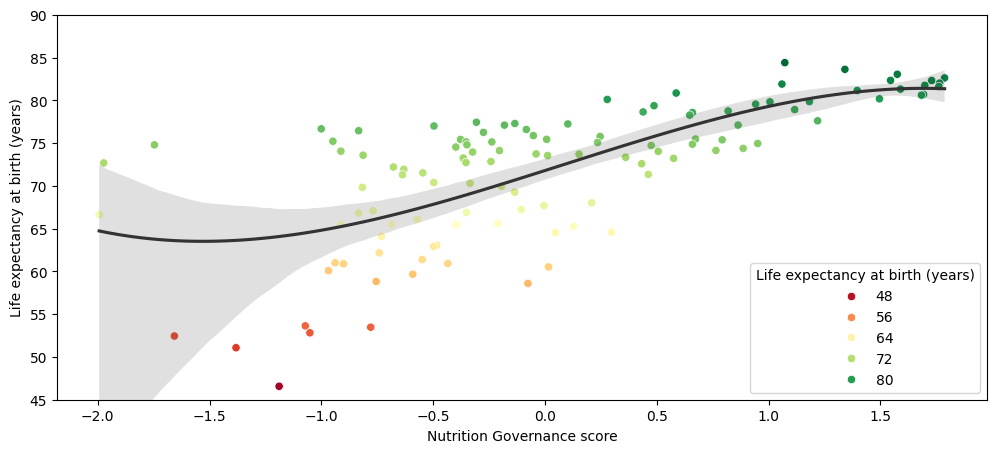

In [330]:
visualise_scatter(x=df.columns[8],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# Cheapest cigarettes price

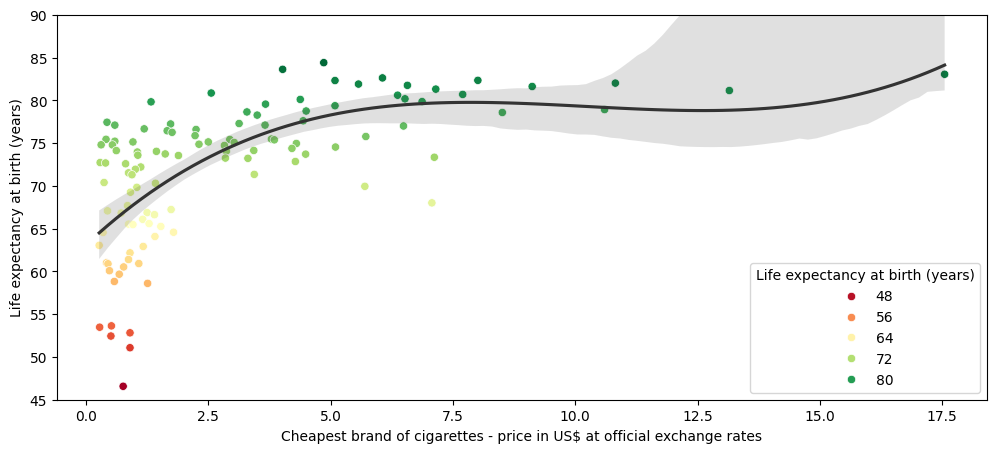

In [331]:
visualise_scatter(x=df.columns[9],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# Percentage of population living below the poverty line

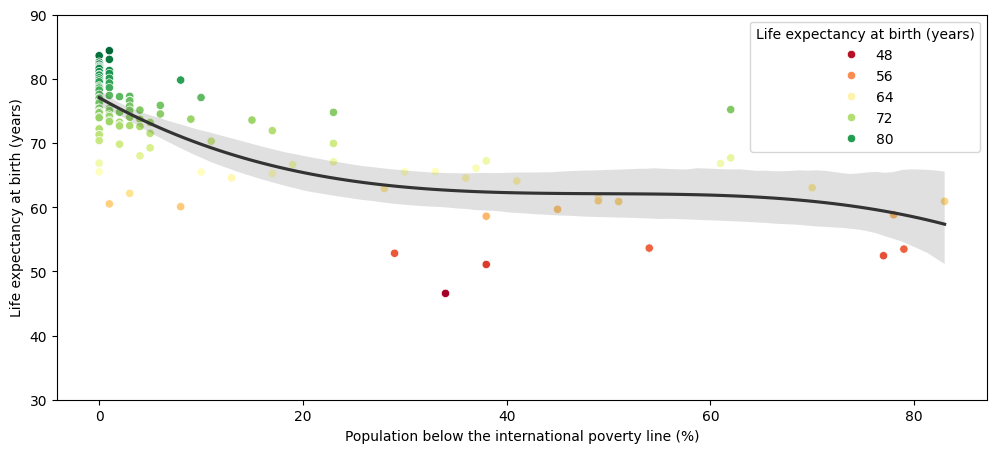

In [332]:
visualise_scatter(x=df.columns[10],y=df.columns[0],data=df,show_reg=True,ylim=(30,90))

# Average price of 500ml beer

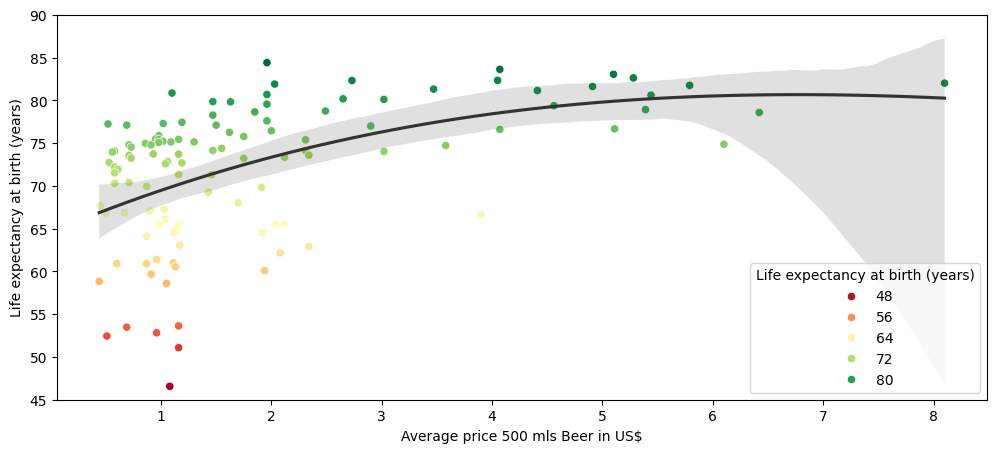

In [333]:
visualise_scatter(x=df.columns[11],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# % of population practising open defecation

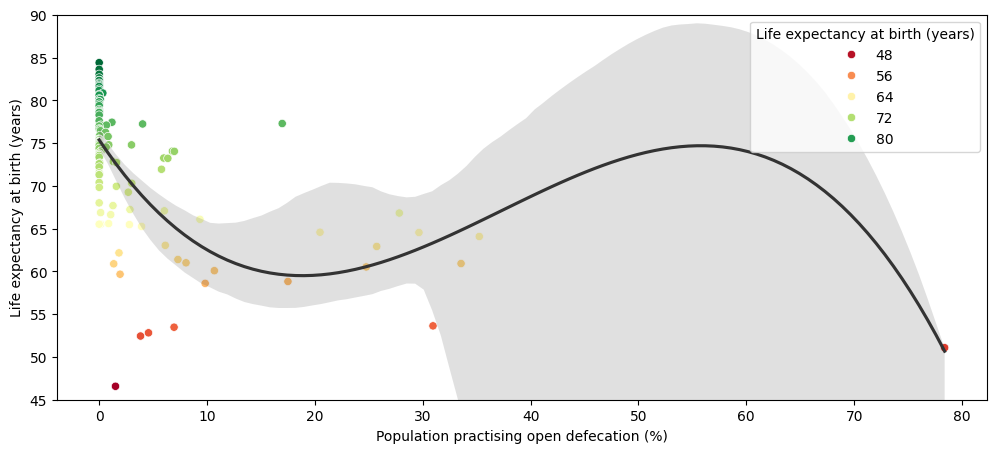

In [334]:
visualise_scatter(x=df.columns[12],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

# CHE as percentage of GPD

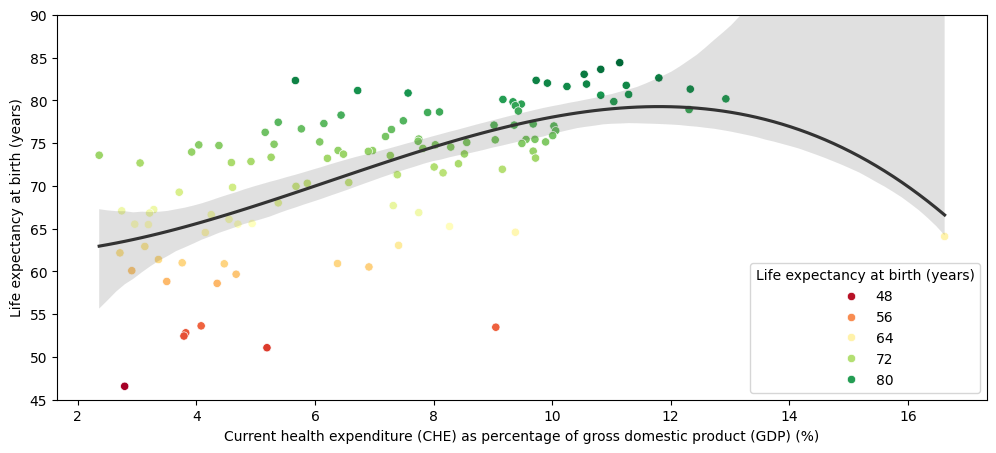

In [335]:
visualise_scatter(x=df.columns[13],y=df.columns[0],data=df,show_reg=True,ylim=(45,90))

In [336]:
df.drop('Population',inplace=True,axis=1)
df.drop(df['Total density per 100 000 population: Hospitals'].name,inplace=True,axis=1)

# Scaling the data

In [337]:
x = df.get(df.columns[1:]).values
y = df[df.columns[0]]
scaler = StandardScaler()
x = scaler.fit_transform(x,y)


# Choosing the best model

Running repetetive tests to measure the average accuracy of different regression models such as: Linear Regression, Ridge, Lasso, Random Forest Regressor and Decision Tree Regressor

Model with the best scoring metrics will be choosen to base further calculations on

<Axes: >

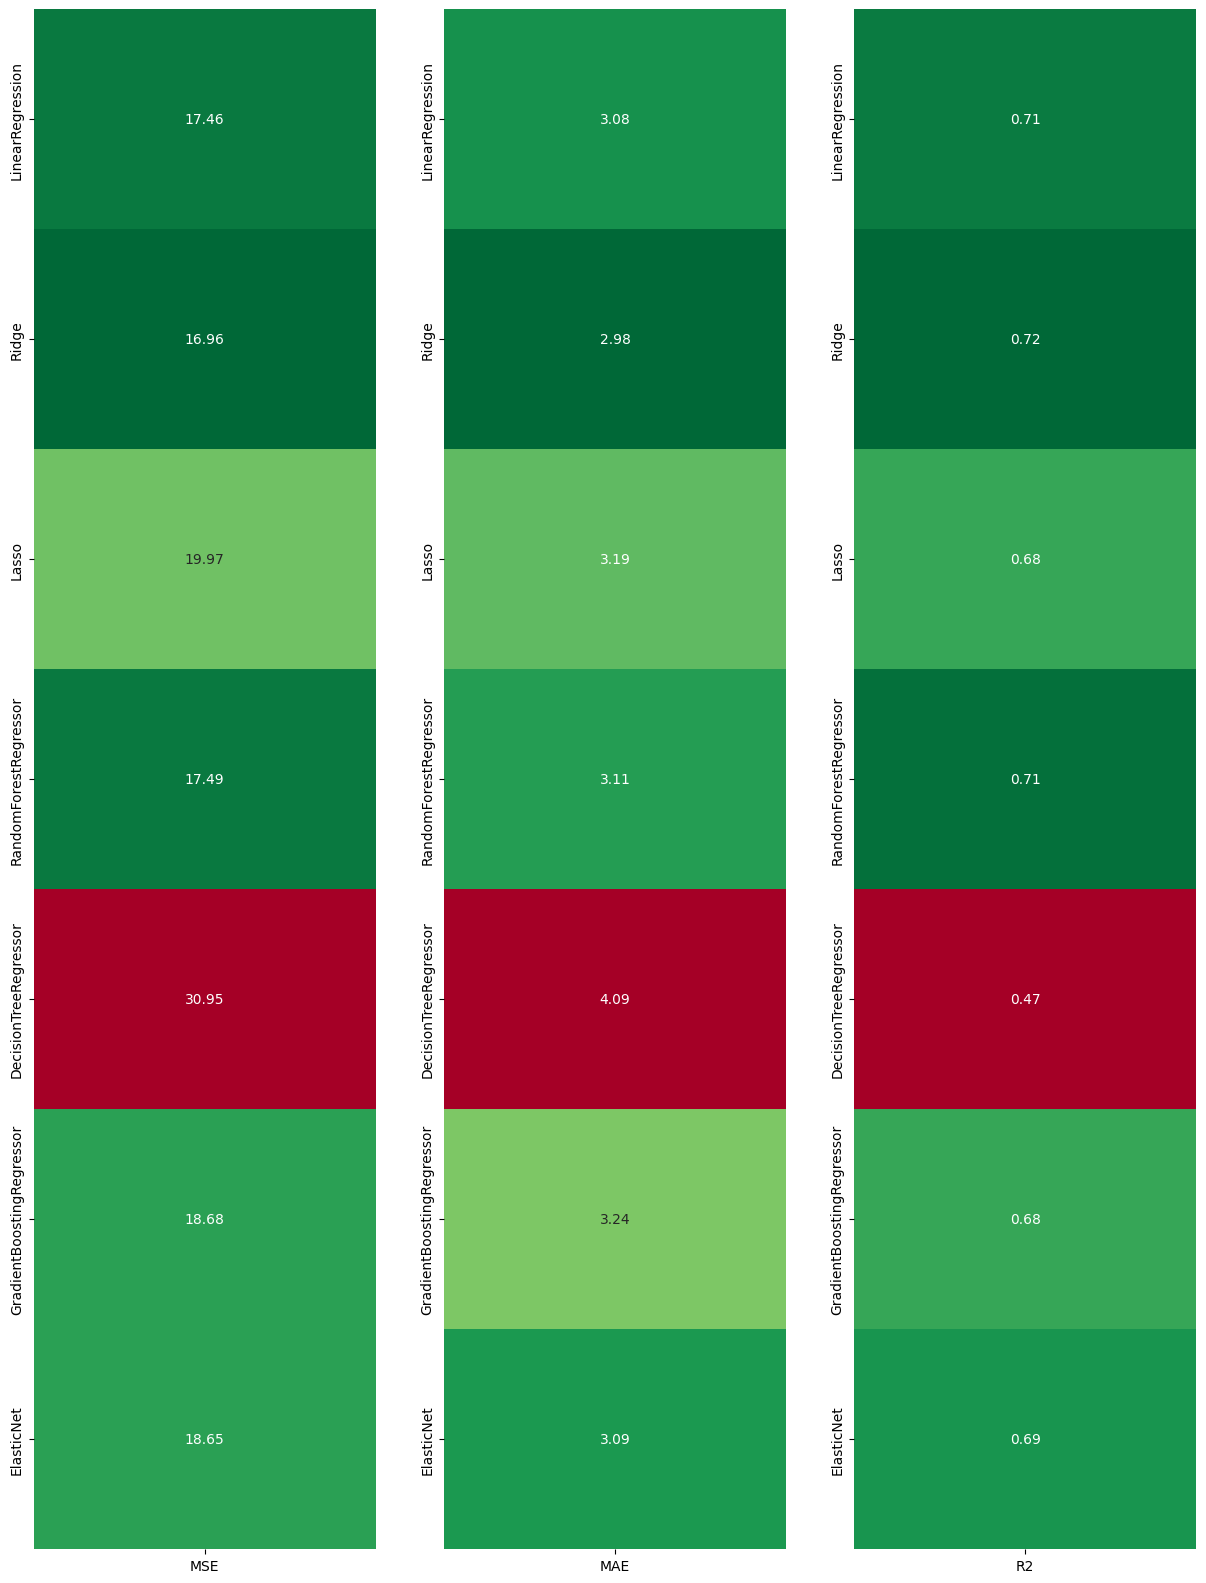

In [338]:
def test_models(x,y,models,repetitions=25):
    '''Tests different models on the dataset and returns results in form of a dictionary with average metrics values'''
    results = {}
    for _ in range(repetitions):
        for model,name  in zip(models,[model.__class__.__name__ for model in models]):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            for metric, metricname in zip([mean_squared_error,mean_absolute_error,r2_score],['MSE','MAE','R2']):
                if name not in results:
                    results[name] = {}
                if metricname not in results[name]:
                    results[name][metricname] = []
                results[name][metricname].append(metric(y_test,y_pred))
                
    for key in results:
        for metric in results[key]:
            results[key][metric] = np.mean(results[key][metric])
    return results

results = test_models(x,y,[LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),DecisionTreeRegressor(),GradientBoostingRegressor(),ElasticNet()],repetitions=250)
results_df = pd.DataFrame(results).T
fig, ax= plt.subplots(ncols=3,figsize=(15,20))
sns.heatmap(results_df[['MSE']],annot=True,fmt='.2f',cmap='RdYlGn_r',ax=ax[0],cbar=False)
sns.heatmap(results_df[['MAE']],annot=True,fmt='.2f',cmap='RdYlGn_r',ax=ax[1],cbar=False)
sns.heatmap(results_df[['R2']],annot=True,fmt='.2f',cmap='RdYlGn',ax=ax[2],cbar=False)


On average both Random Forest Regressor and Gradient Boosting Regressor are the best models, so we will focus on them.


# Choosing best parameters for Random Forest Regressor

In [339]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)


In [340]:
def best_forest_fit(x_train,y_train,x_test,y_test):
    '''Tests different parameters for RandomForestRegressor and returns the best model, its parameters and the score on the training set'''
    best_params = {}
    best_score = 0
    best_model = None
    for n_estimators, min_samples_split, min_samples_leaf,max_features in product([5,10,25,50],[5,10,15],[1,3,5],[0.2,'sqrt','log2',1]):
        model = RandomForestRegressor(n_jobs=1,n_estimators=n_estimators,max_depth=None,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features,random_state=42)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        score = r2_score(y_test,y_pred)
        if score > best_score:
            best_model = model
            best_score = score
            best_params = {'n_estimators':n_estimators,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'max_features':max_features}
    return best_model, best_params

forest_model, forest_params = best_forest_fit(x_train,y_train,x_test,y_test)
print(forest_params)

{'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [341]:
def best_gradient_boosting_fit(x_train,y_train,x_test,y_test):
    '''Tests different parameters for Gradient Boosting Regressor and returns the best model, its parameters'''
    best_params = {}
    best_score = 0
    best_model = None
    for n_estimators, min_samples_split, min_samples_leaf,max_features,learning_rate in product([125,150,200,300],[2,5,10],[1,3,5],[0.2,'sqrt','log2',1],[0.05,0.1,0.2]):
        model = GradientBoostingRegressor(n_estimators=n_estimators,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features,learning_rate=learning_rate,random_state=42)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        score = r2_score(y_test,y_pred)
        if score > best_score:
            best_model = model
            best_score = score
            best_params = {'n_estimators':n_estimators,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'max_features':max_features,'learning_rate':learning_rate}
    return best_model, best_params

gradient_model, gradient_params = best_gradient_boosting_fit(x_train,y_train,x_test,y_test)
print(gradient_params)


{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.2, 'learning_rate': 0.2}


# Linear Regression

In [342]:
def best_ridge_fit(x_train,y_train,x_test,y_test):
    '''Tests different parameters for Gradient Boosting Regressor and returns the best model, its parameters'''
    best_params = {}
    best_score = 0
    best_model = None
    for alpha,solver in product([0.5,1,2,5],['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']):
        model = Ridge(alpha=alpha,solver=solver,random_state=42)
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        score = r2_score(y_test,y_pred)
        if score > best_score:
            best_model = model
            best_score = score
            best_params = {'alpha':alpha,'solver':solver}
    return best_model, best_params

ridge_model, ridge_params = best_ridge_fit(x_train,y_train,x_test,y_test)
print(ridge_params)

{'alpha': 5, 'solver': 'sparse_cg'}


# Comparsion between two models

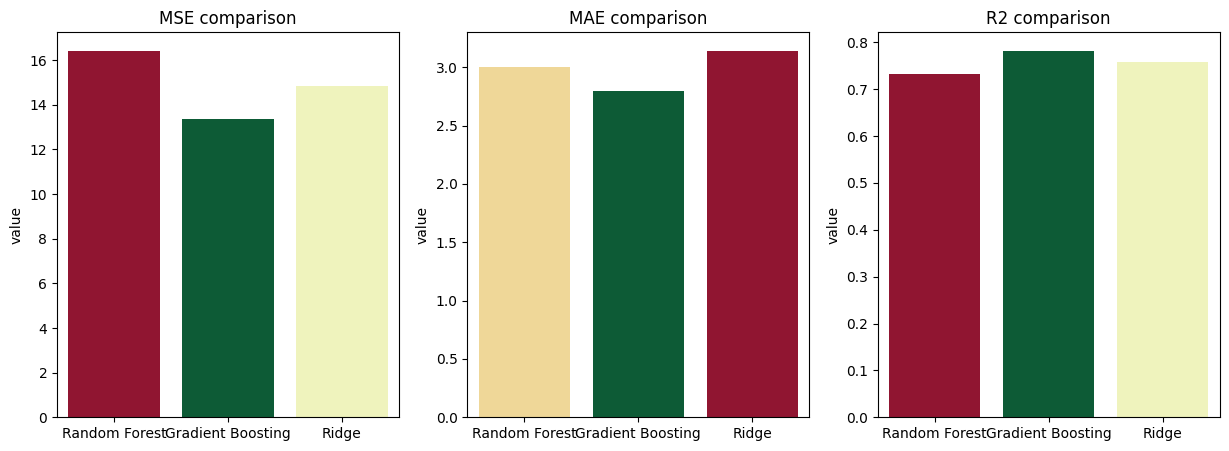

In [352]:
def plot_compare():
    fig, [ax1, ax2, ax3] = plt.subplots(ncols=3,figsize=(15,5))
    for metric,name,ax in zip([mean_squared_error,mean_absolute_error,r2_score],['MSE','MAE','R2'],[ax1,ax2,ax3]):
        y_pred_forest = forest_model.predict(x_test)
        y_pred_gradient = gradient_model.predict(x_test)
        y_pred_ridge = ridge_model.predict(x_test)
        y_values = [metric(y_test,y_pred_forest),metric(y_test,y_pred_gradient),metric(y_test,y_pred_ridge)]
        sns.barplot(x=['Random Forest','Gradient Boosting','Ridge'],y=y_values,hue=y_values,palette=('RdYlGn_r' if name!="R2" else 'RdYlGn') ,ax=ax)
        ax.set_ylabel('value')
        ax.set_title(f'{name} comparison')
        ax.legend().remove()
plot_compare()

# Plotting features importance Random Forest Regressor

C:\Users\dziun\AppData\Local\Temp\ipykernel_14828\917069068.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features,y=model.feature_importances_,palette='viridis')


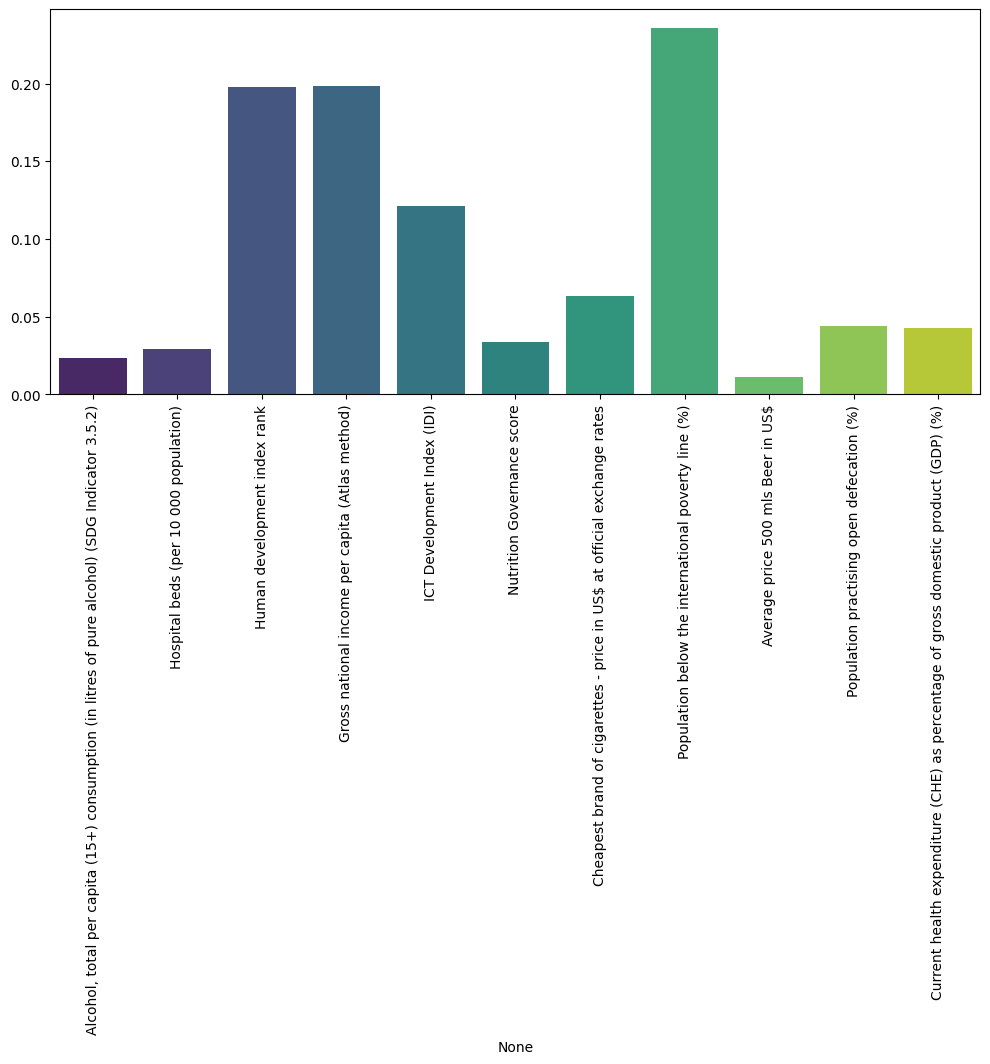

In [344]:
def plot_feature_importance(model,features):
    '''Plots feature importance for a given model'''
    plt.figure(figsize=(12,5))
    sns.barplot(x=features,y=model.feature_importances_,palette='viridis')
    plt.xticks(rotation=90)
    plt.show()
plot_feature_importance(forest_model,df.columns[1:])


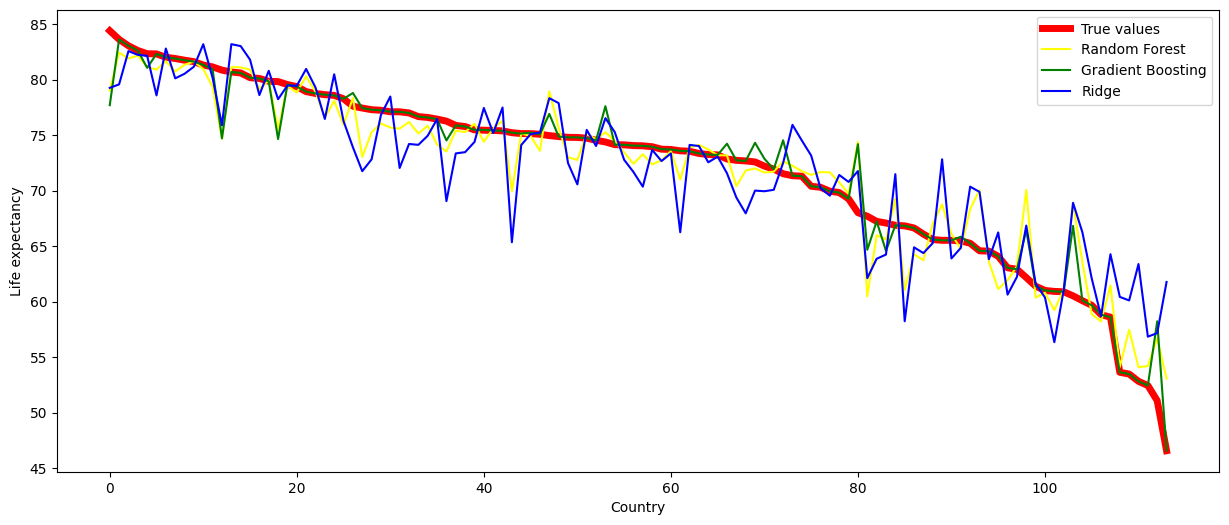

In [345]:
def true_vs_predicted():
    y_pred_forest = forest_model.predict(x)
    y_pred_gradient = gradient_model.predict(x)
    y_pred_ridge = ridge_model.predict(x)
    
    plt.figure(figsize=(15, 6))
    
    plt.plot(df.index, y, label='True values', color='red', linewidth=5)
    plt.plot(df.index, y_pred_forest, label='True values', color='yellow')
    plt.plot(df.index, y_pred_gradient, label='True values', color='green')
    plt.plot(df.index, y_pred_ridge, label='True values', color='blue')
    plt.xscale('linear')
    plt.legend(['True values', 'Random Forest', 'Gradient Boosting', 'Ridge'])

    plt.xlabel('Country')
    plt.ylabel('Life expectancy')

true_vs_predicted()

# Przewidywanie dlugosci życia dla Polski

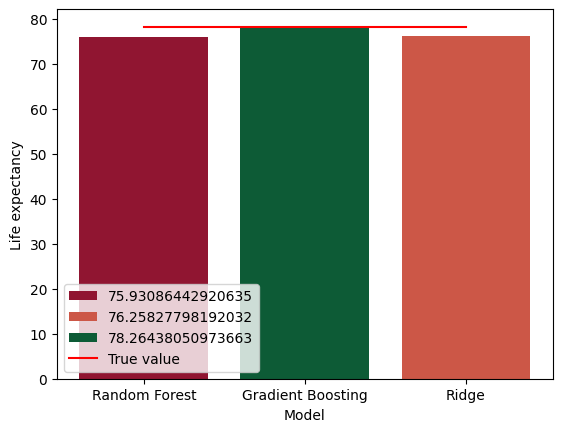

In [358]:
def get_prediction_for_country(country):
    values = df.loc[country].values
    life_expectancy = values[0]
    features = values[1:]
    features = scaler.transform(features.reshape(1,-1))
    life_expectancy_forest = forest_model.predict(features)[0]
    life_expectancy_gradient = gradient_model.predict(features)[0]
    life_expectancy_ridge = ridge_model.predict(features)[0]
    sns.barplot(x=['Random Forest','Gradient Boosting','Ridge'],y=[life_expectancy_forest,life_expectancy_gradient,life_expectancy_ridge],palette='RdYlGn',hue=[life_expectancy_forest,life_expectancy_gradient,life_expectancy_ridge])
    sns.lineplot(y=[life_expectancy,life_expectancy,life_expectancy],x=['Random Forest','Gradient Boosting','Ridge'],color='red',label='True value')
    plt.ylabel('Life expectancy')
    plt.xlabel('Model')
    plt.show()
get_prediction_for_country('Poland')